## About the problem
Given a database where:
*   Each transaction consists of a set of items
*   Each item in a transaction is associated with a utility value, which can be positive or negative
*   The goal is to find the top-k itemsets with the highest utility

**Problem Introduction:**

High-Utility Itemset Mining (HUIM) is a key research area in data mining, focused on identifying itemsets that generate significant profit within databases. Unlike frequent itemset mining, HUIM not only considers the frequency of item occurrences but also includes information about profit, cost, or weight associated with items. This approach provides more insightful and valuable information for managers and business analysts.

**Comparison with Mining Traditional Positive-Profit Databases:**

Most traditional methods in HUIM are designed for databases with only positive profits, meaning they consider only items with positive profit values. However, in many real-world scenarios, transaction databases may contain items with negative profits due to fluctuating values over time or potential losses associated with products. Traditional HUIM methods tend to ignore items with negative profits to avoid reduced accuracy. However, this simplification fails to capture the full picture since, in business, negative profits often represent costs or risks associated with a product.

**The Limitations of Mining Only Positive-Profit Databases:**

Focusing solely on positive-profit items overlooks valuable information about risk and potential losses, leading to a one-sided view of profitability and potentially poor business decisions. For example, products with positive profits but hidden large costs or accumulated losses over time would be overlooked, possibly resulting in suboptimal investment or management strategies.

Thus, there is a need for a new approach to efficiently mine high-utility itemsets from databases with unstable profit values, including both negative and positive. Such an approach would provide a more comprehensive analysis of profit and risk, enabling better-informed management decisions in dynamic business environments.

### Input

The data we’ll use comes from a variety of domains: chess, retail information, mushrooms (the weight or importance of mushroom parts), Kosarak (clickstream data from a Hungarian online news portal), PUMSB (household data and their economic value), and accident data.

#### Data Structure:
The data will be organized as follows:
- **`bagOfData`**: A variable that holds all the datasets mentioned.
- Each **dataset**: A list of transactions, where:
  - Each **transaction** is a dictionary.
  - In each transaction:
    - The key `"items"` holds a list of items.
    - The key `"utilities"` holds a list of corresponding utility values for the items.

#### Code Representation:
```python
bagOfData = {}  # Stores all datasets

# Example structure for a dataset
bagOfData["dataset_name"] = dataset
dataset = []  # List of transactions
dataset.append({'items': items, 'utilities': utilities})  # Adding a transaction
items = []  # List of items in a transaction
utilities = []  # List of corresponding utilities for the items
```

---


### Output
The output will be the **Top-K itemsets** with the highest utility.

The result will be a **list of K itemsets**, where each itemset is represented as a dictionary. In each dictionary:
- The key `"itemset"` will hold the actual itemset (a list of items).
- The key `"utility"` will hold the total sum of utilities for that itemset.

#### Code Representation:
```python
top_k_itemsets = [
    {
        "itemset": ["item_1", "item_2"],  # The itemset (list of items)
        "utility": 10  # The sum of utilities for this itemset
    },
    {
        "itemset": ["item_3", "item_5"],
        "utility": 8
    }
    # More itemsets up to K...
]
```

# Implementation

## Related algorithms

### Importation

In [ ]:
import heapq
import time
import os
from google.colab import drive
import matplotlib.pyplot as plt
from collections import defaultdict, deque

### Load data

In [ ]:
#Mount drive to get data
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def LoadDataInListName(data_namelist):
    bagOfData = {}

    for data_filename in data_namelist:
        path = f"/content/drive/MyDrive/data_negative/{data_filename}.txt"

        # Kiểm tra nếu tệp không tồn tại
        if not os.path.exists(path):
            print(f"File {data_filename}.txt not found!")
            continue

        dataset = []

        # Mở tệp và xử lý từng dòng, giới hạn số dòng tối đa
        try:
            with open(path, 'r') as file:
                for i, line in enumerate(file):
                    if i < 0:
                        break  # Dừng đọc file khi đạt đến giới hạn
                    try:
                        dataset.append(process_line(line))
                    except ValueError:
                        print(f"Skipping line in {data_filename}: {line.strip()}")
        except Exception as e:
            print(f"Error reading {data_filename}: {e}")
            continue

        bagOfData[f"{data_filename}"] = dataset
        print(f"Loaded {data_filename} dataset (max rows).")

    return bagOfData

def process_line(line):
    items_part, total_utility, utilities_part = line.split(':')

    # Cắt bớt số lượng items và utilities
    items = [str(num) for num in items_part.split()]
    utilities = list(map(int, utilities_part.split()))

    return {'items': items, 'utilities': utilities}

# Example usage with large data
data_namelist = ['accident', 'kosarak', 'pumsb', 'retail']
# data_namelist = ['accident', 'pumsb', 'retail']
bagOfData = LoadDataInListName(data_namelist)

Loaded accident dataset (max rows).
Skipping line in kosarak: 6 215 83 278 7 205
Loaded kosarak dataset (max rows).
Skipping line in pumsb: 2 15 17 58 68 75 84 111 158 161 167 168 170 180 184 188 197 252 260 265 277 290 1297 2297
Loaded pumsb dataset (max rows).
Loaded retail dataset (max rows).


In [ ]:
print(bagOfData.keys())

dict_keys(['accident', 'kosarak', 'pumsb', 'retail'])


In [ ]:
for dataset in bagOfData:
  print(f"Length of {dataset} dataset: {len(bagOfData[dataset])}")

Length of accident dataset: 51313
Length of kosarak dataset: 294682
Length of pumsb dataset: 47473
Length of retail dataset: 88162


In [ ]:
def showDataInBag(bagOfData):
  NUM_OF_TRANSACTION_SHOW = 10
  for data_filename, dataset in bagOfData.items():
    transaction_index=1
    print(f"==========={data_filename} Dataset==========")
    for transaction in dataset[:NUM_OF_TRANSACTION_SHOW]:
      print(f"Transaction {transaction_index}:")
      items = transaction['items']
      utilities = transaction['utilities']
      print(f"Items: {', '.join(items)}\nUtilities: {', '.join(map(str, utilities))}")
      print()
      transaction_index += 1
showDataInBag(bagOfData)

===========accident Dataset==========
Transaction 1:
Items: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31
Utilities: -10, 8, 36, 5, -9, 18, 7, 6, 15, -15, 49, -6, -8, -12, -6, -27, 21, 40, 24, 12, 63, -5, -20, 10, -50, 10, -10, 4, -16, -7, -24

Transaction 2:
Items: 2, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39
Utilities: 6, -9, 1, 30, 6, -50, -36, -40, -24, -2, -27, 6, 40, 12, -4, -14, 4, -40, -4, 16, -12, -9, 45, -70, 90, -18, 21, -24, -14

Transaction 3:
Items: 7, 10, 12, 13, 14, 15, 16, 17, 18, 20, 25, 28, 29, 30, 33, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52
Utilities: 9, -25, -36, -20, -27, -4, -18, 18, 20, 36, -30, 6, -2, -7, 40, -12, 10, 49, -28, -70, 12, -15, -8, -14, -36, -20, -10, -15

Transaction 4:
Items: 1, 5, 8, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 41, 43, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57

In [ ]:
test_transactions = [
    {'items': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'utilities': [-6, 14, 10, -10, -3, -48, 16, 20, 3, -18, 12, -6]},
    {'items': ['30', '31', '32'], 'utilities': [6, -8, 20]},
    {'items': ['33', '34', '35'], 'utilities': [4, -9, 12]},
    {'items': ['36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46'], 'utilities': [48, -15, 56, 4, -9, -12, 21, 3, 10, 35, -27]},
    {'items': ['38', '39', '47', '48'], 'utilities': [42, 8, 12, -40]},
    {'items': ['38', '39', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58'], 'utilities': [14, 10, -50, -20, -16, 10, 9, -16, 35, 21, 9, 12, 21]},
    {'items': ['32', '41', '59', '60', '61', '62'], 'utilities': [32, -20, -12, 8, -30, -8]},
    {'items': ['3', '39', '48'], 'utilities': [-8, 14, -10]},
    {'items': ['63', '64', '65', '66', '67', '68'], 'utilities': [12, 30, 3, -21, 16, -25]},
    {'items': ['32', '69'], 'utilities': [36, 5]}
]

### Utility Tree example

#### Example Transactions
We will define transactions with items and their associated utilities:

```python
# Define transactions
transactions = [
    {'items': ['1', '2', '3'], 'utilities': [-5, 10, 20]},
    {'items': ['2', '4'], 'utilities': [15, -8]},
    {'items': ['1', '4'], 'utilities': [-10, 25]}
]

```

#### Utility Tree Structure

- [ ]
    - [1]
        - [1,4] (Utility: 15)
    - [2]
        - [2,4] (Utility: 7)
        - [2,3] (Utility: 20)


### UP-GNIV

####  **Components of the Algorithm**

##### **Step 1: Parsing Input Data**
The input consists of multiple transactions, where each transaction is represented as a dictionary with two keys: `'items'` and `'utilities'`. The `'items'` key holds a list of item indices, and the `'utilities'` key holds the corresponding utility values (both positive and negative).

- **Input format:**
    - Each transaction is represented as a dictionary with two lists: one for item indices and one for utility values.
  
- **Example:**
  ```python
  transactions = [
      {'items': ['1', '2', '3', '4'], 'utilities': [-10, 8, 36, 5]},
      {'items': ['2', '5', '7', '8'], 'utilities': [6, -9, 1, 30]},
      {'items': ['7', '10', '12', '13'], 'utilities': [9, -25, -36, -20]},
      {'items': ['1', '5', '8', '10'], 'utilities': [-6, -8, 18, -10]},
      {'items': ['5', '8', '10', '12'], 'utilities': [-9, 24, -50, -12]}
  ]
  ```
---

##### **Step 2: Generate All Possible Itemsets**
For each transaction, the algorithm generates all possible subsets (itemsets) from the list of items and computes the total utility by summing up the corresponding utility values.

- **Combination generation:**
  The algorithm will create subsets from the `items` list in each transaction and use the corresponding values from the `utilities` list.

- **Example:**
  For the transaction `{'items': ['1', '2'], 'utilities': [-10, 8]}`, the algorithm generates subsets such as `['1']` with utility `-10`, `['2']` with utility `8`, and `['1', '2']` with utility `-2` (`-10 + 8`).

---

#####  **Step 3: Compute Utility of Itemsets**
For each itemset generated, the total utility is calculated by summing up the utilities of the items in the set. Both positive and negative utilities are considered.

- **Example:**
  ```python
  itemset = ['A', 'B']
  utilities = [5, -3]
  total_utility = sum(utilities)  # 5 + (-3) = 2
  ```
---

#####  **Step 4: Construct Utility Tree**
The algorithm constructs a **Utility Tree** similar to the FP-Tree, where nodes represent items and their associated utilities. The tree allows efficient storage and mining of itemsets, using paths to represent transactions.

- **Tree Construction:**
  The tree is built by inserting each transaction into the tree, following the order of the itemsets generated earlier, and accumulating utility values at each node.

- **Header Table:**
  A header table is used to keep track of the starting points for each item in the tree, allowing efficient mining of itemsets.

---

#####  **Step 5: Mine the Utility Tree**
The tree is recursively mined to find high-utility patterns. During the mining process, negative itemsets are handled by adjusting the utility values. If a node's utility falls below a given minimum threshold (including the effect of negative utilities), the node is pruned.

- **Mining Process:**
  The algorithm starts from the header table, follows the node links, and constructs itemsets with their utilities. Only itemsets that meet the minimum utility threshold are retained.

---

#####  **Step 6: Sort and Select Top-k Itemsets**
Once all itemsets have been mined from the tree, the algorithm sorts them based on their total utility values. It then selects the top-k itemsets with the highest utilities.

- **Sorting criteria:**
  - Itemsets are sorted in descending order of their total utility.
  - If two itemsets have the same utility, other criteria such as the size of the itemset or lexicographical order can be used to break the tie.

---

#####  **Step 7: Return Top-k Results**
The final step is to return the top-k high-utility itemsets as the result. These itemsets represent the most significant patterns (positive or negative) based on their utility values.

- **Output format:**
  The output is a list of top-k itemsets along with their total utilities.

- **Example:**
  ```python
  top_k_itemsets = [
      (['A', 'C'], 13),
      (['C'], 7),
      (['A'], 5)
  ]
  ```

In [ ]:
class UtilityTreeNode:
    def __init__(self, item=None, utility=0, parent=None):
        self.item = item
        self.utility = utility
        self.parent = parent
        self.children = {}
        self.count = 0
        self.subtree_utility = 0

    def add_child(self, child_item, utility):
        if child_item not in self.children:
            self.children[child_item] = UtilityTreeNode(child_item, utility, self)
        return self.children[child_item]

class UtilityTree:
    def __init__(self) -> None:
        self.root = UtilityTreeNode(None)
        self.header_table = {}
        self.patterns = []  # To store mined patterns

    def insert_transaction(self, items: list[str], utilities: list[int]) -> None:
        current_node = self.root
        for item, utility in zip(items, utilities):
            current_node = current_node.add_child(item, utility)
            current_node.count += 1
            current_node.utility += utility


    def mine_patterns(self, min_utility: int) -> None:
        # A basic version of mining patterns
        self._mine_node(self.root, [], min_utility)

    def _mine_node(self, node: 'UtilityTreeNode', current_pattern: list[tuple[str,int]], min_utility: int) -> None:
        if node.item:
            current_pattern.append((node.item, node.utility))

        total_utility = sum([utility for _, utility in current_pattern])

        # If pattern meets the utility threshold, store it
        if total_utility >= min_utility:
            self.patterns.append((current_pattern[:], total_utility))  # Store the pattern and its utility

        for child in node.children.values():
            self._mine_node(child, current_pattern[:], min_utility)  # Recursive mining

In [ ]:
class UPGNIV:
    def __init__(self, transactions: list[dict[str, list[int]]], min_utility: int) -> None:
        """
        Initialize the UP-GNIV algorithm with transaction data and minimum utility value.

        :param transactions: List of transactions, each being a dictionary with 'items' and 'utilities'.
        :param min_utility: Minimum utility value for mining patterns.
        """
        self.transactions = transactions
        self.min_utility = min_utility
        self.tree = UtilityTree()

    def calculate_utility(self, items: list[str], utilities: list[int]) -> int:
        """
        Calculate the total utility of items in a transaction.

        :param items: List of items in the transaction.
        :param utilities: List of corresponding utilities for the items in the transaction.
        :return: Total utility.
        """
        return sum(utilities)

    def run(self, verbose: bool = True, k=None) -> None:
        """
        Execute the UP-GNIV algorithm to mine high-utility patterns.
        """
        # Read and process transactions: insert into the utility tree if the utility is sufficient
        for transaction in self.transactions:
            items = transaction['items']
            utilities = transaction['utilities']
            transaction_utility = self.calculate_utility(items, utilities)
            if transaction_utility >= self.min_utility:
                self.tree.insert_transaction(items, utilities)

        # Mine patterns with positive and negative items
        self.tree.mine_patterns(self.min_utility)

        # Print the mining results
        self.print_results(verbose, k)

    def print_results(self, verbose: bool = True, top_k: int = None) -> None:
        """
        Print the mined patterns (itemsets and their utilities), optionally limited to top-k by utility.

        :param verbose: Flag to enable/disable printing.
        :param top_k: Number of top patterns to display based on utility.
        """
        if verbose:
            print("Mined Patterns (itemset and utility):")
            # Sort patterns by total utility in descending order
            sorted_patterns = sorted(self.tree.patterns, key=lambda x: x[1], reverse=True)

            # If top_k is specified, limit the results
            if top_k:
                sorted_patterns = sorted_patterns[:top_k]

            for pattern, utility in sorted_patterns:
                items = [item for item, _ in pattern]
                utilities = [utility for _, utility in pattern]
                print(f"Items: {items}, Utilities: {utilities}, Total Utility: {utility}")

    def benchmark_test(self, verbose: bool = False, k = None) -> float:
        """
        Benchmark the execution time of the entire UP-GNIV algorithm.

        :param verbose: Flag to control detailed output during the run.
        :return: Total execution time.
        """
        start_time = time.time()

        # Execute the algorithm
        self.run(verbose, k)

        end_time = time.time()

        # Calculate and return the execution time
        total_time = end_time - start_time
        return total_time

In [ ]:
min_utility = 5
k = 10
upgniv_algorithm = UPGNIV(test_transactions, min_utility)

upgniv_algorithm.benchmark_test(verbose = True, k = k)


Mined Patterns (itemset and utility):
Items: ['36', '37', '38', '39', '40', '41', '42', '43', '44', '45'], Utilities: [96, -30, 112, 8, -18, -24, 42, 6, 20, 70], Total Utility: 282
Items: ['36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46'], Utilities: [96, -30, 112, 8, -18, -24, 42, 6, 20, 70, -54], Total Utility: 228
Items: ['36', '37', '38', '39', '40', '41', '42', '43', '44'], Utilities: [96, -30, 112, 8, -18, -24, 42, 6, 20], Total Utility: 212
Items: ['36', '37', '38', '39', '40', '41', '42', '43'], Utilities: [96, -30, 112, 8, -18, -24, 42, 6], Total Utility: 192
Items: ['36', '37', '38', '39'], Utilities: [96, -30, 112, 8], Total Utility: 186
Items: ['36', '37', '38', '39', '40', '41', '42'], Utilities: [96, -30, 112, 8, -18, -24, 42], Total Utility: 186
Items: ['36', '37', '38'], Utilities: [96, -30, 112], Total Utility: 178
Items: ['36', '37', '38', '39', '40'], Utilities: [96, -30, 112, 8, -18], Total Utility: 168
Items: ['38', '39', '48', '49', '50', '51', '52

0.0003268718719482422

### HUSP-NIV

**HUSP-NIV** is an algorithm designed for mining high-utility sequential patterns, even when negative items are involved in the dataset. This approach can be adapted for Top-K High-Utility Itemset mining as follows:




####  **Components of the Algorithm**

 **Example dataset**


``` python
bagOfData = {
    "dataset1": [
        {"items": ["A", "B", "C", "D"], "utilities": ["10", "15", "5", "20"]},
        {"items": ["A", "E", "F"], "utilities": ["10", "5", "10"]},
        {"items": ["G", "H"], "utilities": ["15", "25"]},
        {"items": ["A", "B"], "utilities": ["10", "5"]},
        {"items": ["C", "D", "F"], "utilities": ["5", "10", "15"]},
        {"items": ["H", "E", "G"], "utilities": ["25", "5", "15"]},
    ]
}

```
---

##### **Step 1: Dynamic Utility Update (update_utilities_dynamically)**

This step updates item utilities dynamically by introducing random fluctuations, making the data more reflective of real-world scenarios. It applies predefined limits on transactions and items per transaction.

- **Input:** bagOfData as defined above, with MAX_TRANSACTIONS_PER_DATASET=5 and MAX_ITEMS_PER_TRANSACTION=3

- **Example Output:**
``` python
dataset: [{'A': 12.0, 'B': 18.0, 'C': 4.0}, {'A': 8.0, 'E': 6.0, 'F': 9.0}, {'G': 14.0, 'H': 30.0}]
```

---

##### **Step 2: Utility Tree Construction (construct_utility_tree)**

To organize transactions in a tree structure based on item sequences, enabling efficient utility calculations for high-utility sequential pattern mining. Each node represents an item with accumulated utility.

- **Input:** database (transaction data from Step 1), MAX_TRANSACTIONS_PER_DATASET=5, MAX_ITEMS_PER_TRANSACTION=3
  
- **Process:**  Constructs a utility tree where each path represents a transaction sequence, and nodes store cumulative utility values.

- **Example Output:**

``` python
Utility Tree:
Root
├─ A (Utility: 20)
│  └─ B (Utility: 12)
└─ G (Utility: 25)
```
---

##### **Step 3: High-Utility Sequential Pattern Mining (husp_niv)**

To identify high-utility sequential patterns within a dataset by traversing the utility tree and summing the utility for each sequence that meets or exceeds a minimum threshold. Supports top-k retrieval.

- **Input:** updated_bagOfData (from Step 1), min_utility=5, k=2

  
- **Process:**  Finds sequences with utility ≥ min_utility and uses a heap to retrieve the top-k highest-utility patterns.

- **Example Output:**

``` python
Top 2 High-Utility Sequential Patterns for dataset1:
Sequence: ['A', 'B'], Utility: 12
Sequence: ['G', 'H'], Utility: 30
```
---

##### **Step 4: Utility Calculation for Transactions (calculate_transaction_utility)**

This function calculates the total utility of each transaction, enabling easier comparison of transaction-level utilities

- **Input:** A transaction, represented as a dictionary of {item: utility} pairs.

  
- **Process:**  Sums up the utility values of items within a transaction.

- **Example Code:**

``` python
def calculate_transaction_utility(transaction):
    return sum(transaction.values())
```
---

- **Example Usage:**

``` python
transaction = {"A": 12.0, "B": 18.0, "C": 4.8}
print(calculate_transaction_utility(transaction))  # Output: 34.8
```
---

##### **Step 5: Sequence Utility Calculation within Transaction Context (calculate_sequence_utility)**

This function calculates the utility of a given sequence within a transaction by summing up the utility of items present in both the sequence and transaction, limited by MAX_SEQUENCE_LENGTH.

- **Input:**
  - *sequence*: A list of items.
  - *transaction*: A dictionary with items and their utilities.

  
- **Process:**  Sums up the utility values of items within a transaction.

- **Example Code:**

``` python
def calculate_sequence_utility(sequence, transaction):
    utility = 0
    for item in sequence[:MAX_SEQUENCE_LENGTH]:
        if item in transaction:
            utility += transaction[item]
    return utility

```

- **Example Usage:**

``` python
sequence = ["A", "B", "C"]
transaction = {"A": 10, "B": 5, "C": 15}
print(calculate_sequence_utility(sequence, transaction))  # Output: 15
```

In [ ]:
class UtilityTreeNode_HUSPNIV:
    def __init__(self, item=None, parent=None):
        """
        Initialize a node in the utility tree.

        :param item: The item associated with this node.
        :param parent: The parent node.
        """
        self.item = item
        self.parent = parent
        self.children = {}
        self.count = 0
        self.utility = 0  # Actual utility of the sequence ending at this node.
        self.subtree_utility = 0  # SWU: Sequence-Weighted Utility for pruning.

In [ ]:
class HUSP_NIV:
    def __init__(self, dataset : list[dict],  min_utility : int):
        """
        Initialize the HUSP_NIV algorithm.

        :param min_utility: The minimum utility threshold for mining patterns.
        """
        self.dataset = dataset
        self.min_utility = min_utility
        self.patterns = []

    def calculate_item_swu(self, database):
        """
        Calculate the Sequence-Weighted Utility (SWU) for each item.

        :param database: The transactional database.
        :return: A dictionary mapping items to their SWU values.
        """
        item_swu = {}
        for transaction in database:
            transaction_utility = sum(transaction.values())
            for item in transaction:
                if item not in item_swu:
                    item_swu[item] = 0
                item_swu[item] += transaction_utility
        return item_swu

    def construct_utility_tree(self, database, item_swu):
        """
        Construct the utility tree from the database.

        :param database: The filtered transactional database.
        :param item_swu: Dictionary of items and their SWU values.
        :return: The root node of the utility tree.
        """
        root = UtilityTreeNode_HUSPNIV()
        for transaction in database:
            current_node = root
            # Reorder items in the transaction based on SWU descending
            sorted_items = sorted(transaction.items(), key=lambda x: item_swu.get(x[0], 0), reverse=True)
            transaction_utility = sum(transaction.values())
            for item, utility in sorted_items:
                if item not in current_node.children:
                    current_node.children[item] = UtilityTreeNode_HUSPNIV(item, current_node)
                current_node = current_node.children[item]
                current_node.count += 1
                current_node.utility += utility  # Actual utility in transactions
                current_node.subtree_utility += transaction_utility  # Update SWU
        return root

    def _husp_niv(self, node, current_sequence, current_utility, item_swu):
        """
        Recursive function to mine high-utility sequential patterns.

        :param node: The current node in the utility tree.
        :param current_sequence: The current sequence of items.
        :param current_utility: The utility of the current sequence.
        :param item_swu: Dictionary of items and their SWU values.
        """
        if node.item is not None:
            current_sequence.append(node.item)
            current_utility += node.utility

            # Check if current sequence is a high-utility pattern
            if current_utility >= self.min_utility:
                self.patterns.append((current_sequence.copy(), current_utility))

            # Prune if SWU of the node's subtree is less than min_utility
            if node.subtree_utility < self.min_utility:
                current_sequence.pop()
                return

        # Recursively explore child nodes
        for child in node.children.values():
            self._husp_niv(child, current_sequence, current_utility, item_swu)

        if node.item is not None:
            current_sequence.pop()

    def husp_niv(self, database, k=None):
        """
        Main function to perform high-utility sequential pattern mining.

        :param database: The transactional database.
        :param k: The number of top patterns to retrieve (optional).
        :return: A list of high-utility sequential patterns.
        """
        # Calculate Sequence-Weighted Utility (SWU) for each item
        item_swu = self.calculate_item_swu(database)

        # Remove items with SWU less than min_utility and filter transactions
        filtered_database = []
        for transaction in database:
            filtered_transaction = {
                item: utility
                for item, utility in transaction.items()
                if item_swu.get(item, 0) >= self.min_utility
            }
            if filtered_transaction:
                filtered_database.append(filtered_transaction)

        # Construct the utility tree
        root = self.construct_utility_tree(filtered_database, item_swu)

        # Initialize patterns list
        self.patterns = []

        # Start mining from the root node
        self._husp_niv(root, [], 0, item_swu)

        # Get top-k patterns if k is specified
        if k is not None:
            return heapq.nlargest(k, self.patterns, key=lambda x: x[1])
        else:
            return self.patterns

    def update_utilities_dynamically(self, transactions):
        """
        Update the utilities of items in transactions dynamically.

        :param transactions: A list of transactions.
        :return: The updated list of transactions with modified utilities.
        """
        updated_transactions = []
        for transaction in transactions:
            items = transaction['items']
            utilities = transaction['utilities']

            updated_utilities = []
            for utility_str in utilities:
                try:
                    utility = float(utility_str)
                    updated_utility = round(utility, 2)
                    updated_utilities.append(updated_utility)
                except ValueError:
                    print(f"Invalid utility value: {utility_str}. Skipping.")
                    continue

            updated_transaction = dict(zip(items, updated_utilities))
            updated_transactions.append(updated_transaction)
        return updated_transactions

    def run(self, k=None, verbose=True):
        """
        Execute the HUSP_NIV algorithm on the provided transactions.

        :param transactions: A list of transactions.
        :param k: The number of top patterns to retrieve (optional).
        :param verbose: If True, prints the patterns.
        :return: A list of high-utility sequential patterns.
        """
        # Update utilities dynamically
        updated_transactions = self.update_utilities_dynamically(self.dataset)
        # Perform high-utility sequential pattern mining
        high_utility_sequences = self.husp_niv(updated_transactions, k)

        if verbose:
            # print(f"Top {k if k else ''} High-Utility Sequential Patterns:")
            for sequence, utility in high_utility_sequences:
                print(f"Items: {sequence}, Utility: {utility}")

        return high_utility_sequences

    def benchmark_test(self, k=None, verbose=False) -> float:
        """
        Measure the execution time of the algorithm.

        :param transactions: A list of transactions.
        :param k: The number of top patterns to retrieve (optional).
        :param verbose: If True, prints the patterns.
        :return: Total execution time in seconds.
        """
        start_time = time.time()

        self.run(k, verbose)

        end_time = time.time()
        total_time = end_time - start_time
        return total_time

In [ ]:
min_utility = 5
k = 10
huspniv_algorithm = HUSP_NIV(dataset=test_transactions, min_utility=min_utility)

huspniv_algorithm.benchmark_test(k=k, verbose = True)

Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45'], Utility: 227.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45', '46'], Utility: 200.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44'], Utility: 192.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45', '46', '41'], Utility: 188.0
Items: ['38', '39', '36'], Utility: 182.0
Items: ['38', '39', '36', '37', '40', '42', '43'], Utility: 182.0
Items: ['38', '39', '36', '37', '40', '42'], Utility: 179.0
Items: ['38', '39', '36', '37'], Utility: 167.0
Items: ['38', '39', '36', '37', '40'], Utility: 158.0
Items: ['38', '39'], Utility: 134.0


0.00036334991455078125

### NEGLECT

#### **Components of the Algorithm**

---

#### **Example Dataset**

```python
dataset1 = [
    {"items": ["A", "B", "C", "D"], "utilities": ["10", "15", "5", "20"]},
    {"items": ["A", "E", "F"], "utilities": ["10", "5", "10"]},
    {"items": ["G", "H"], "utilities": ["15", "25"]},
    {"items": ["A", "B"], "utilities": ["10", "5"]},
    {"items": ["C", "D", "F"], "utilities": ["5", "10", "15"]},
    {"items": ["H", "E", "G"], "utilities": ["25", "5", "15"]},
]
```

---

#### **Step 1: Transaction Preparation (prepare_transactions)**

This step converts each transaction's items and utilities into a dictionary format, enabling easier utility calculations and filtering.

- **Input:** Dataset as shown above.
  
- **Process:** Combines items and their respective utilities into a dictionary for each transaction.

- **Example Output:**

```python
Prepared Transactions: [
    {'A': 10.0, 'B': 15.0, 'C': 5.0, 'D': 20.0},
    {'A': 10.0, 'E': 5.0, 'F': 10.0},
    {'G': 15.0, 'H': 25.0},
    {'A': 10.0, 'B': 5.0},
    {'C': 5.0, 'D': 10.0, 'F': 15.0},
    {'H': 25.0, 'E': 5.0, 'G': 15.0}
]
```

---

#### **Step 2: Sequence-Weighted Utility Calculation (calculate_swu)**

To calculate the Sequence-Weighted Utility (SWU) for each item, summing up the utility of each transaction where the item appears.

- **Input:** Prepared transactions from Step 1.
  
- **Process:** Calculates SWU by summing the total utility of transactions containing each item.

- **Example Output:**

```python
SWU: {'A': 50.0, 'B': 30.0, 'C': 35.0, 'D': 35.0, 'E': 15.0, 'F': 25.0, 'G': 55.0, 'H': 65.0}
```

---

#### **Step 3: Utility Tree Construction (construct_tree)**

This step organizes transactions in a tree structure based on item sequences, enabling efficient utility calculations. Each node in the tree represents an item and stores its cumulative utility.

- **Input:** Filtered transactions based on SWU from Step 2.
  
- **Process:** Constructs a utility tree where paths represent item sequences, and nodes store utility values.

- **Example Output:**

```
Utility Tree:
Root
├─ A (Utility: 30)
│  └─ B (Utility: 20)
├─ G (Utility: 30)
└─ H (Utility: 50)
```

---

#### **Step 4: High-Utility Pattern Mining (_neglect_mine)**

This function mines high-utility patterns by traversing the utility tree and summing utilities for each sequence. It identifies patterns meeting or exceeding the minimum utility threshold.

- **Input:** Utility tree and minimum utility threshold.
  
- **Process:** Recursively traverses the tree, accumulating utility and recording sequences with utility above the threshold.

- **Example Output:**

```python
Patterns Found: [
    (['A', 'B'], 35.0),
    (['G', 'H'], 55.0)
]
```

---

#### **Step 5: Top-k Pattern Extraction (run_neglect)**

This step retrieves the top-k patterns with the highest utility using a heap-based approach.

- **Input:** Mined patterns from Step 4 and `k` (number of patterns to return).
  
- **Process:** Uses a max-heap to select the top-k patterns based on utility.

- **Example Output:**

```python
Top 2 Patterns: [
    (['G', 'H'], 55.0),
    (['A', 'B'], 35.0)
]
```

In [ ]:
class UtilityTreeNode_NEGLECT:
    def __init__(self, item=None, parent=None):
        self.item = item
        self.parent = parent
        self.children = {}
        self.utility = 0  # Utility của item tại node này.
        self.subtree_utility = 0  # SWU (Sequence-Weighted Utility).

class NEGLECT:
    def __init__(self, dataset: list[dict], min_utility: int):
        self.dataset = dataset
        self.min_utility = min_utility
        self.patterns = []

    def prepare_transactions(self):
        """Chuyển đổi dataset từ dạng items và utilities sang dictionary."""
        transactions = []
        for transaction in self.dataset:
            items = transaction["items"]
            utilities = list(map(float, transaction["utilities"]))
            transactions.append(dict(zip(items, utilities)))
        return transactions

    def calculate_swu(self, transactions):
        """Tính toán SWU cho từng item."""
        swu = {}
        for transaction in transactions:
            transaction_utility = sum(transaction.values())
            for item in transaction:
                if item not in swu:
                    swu[item] = 0
                swu[item] += transaction_utility
        return swu

    def construct_tree(self, transactions, swu):
        """Xây dựng Utility Tree từ dữ liệu đã lọc."""
        root = UtilityTreeNode_NEGLECT()
        for transaction in transactions:
            sorted_items = sorted(transaction.items(), key=lambda x: swu[x[0]], reverse=True)
            current_node = root
            for item, utility in sorted_items:
                if item not in current_node.children:
                    current_node.children[item] = UtilityTreeNode_NEGLECT(item, current_node)
                current_node = current_node.children[item]
                current_node.utility += utility
                current_node.subtree_utility += sum(transaction.values())
        return root

    def _neglect_mine(self, node, sequence, utility, swu):
        """Hàm đệ quy khai thác các mẫu tuần tự có utility cao."""
        if node.item is not None:
            sequence.append(node.item)
            utility += node.utility

            if utility >= self.min_utility:
                self.patterns.append((sequence.copy(), utility))

            if node.subtree_utility < self.min_utility:
                sequence.pop()
                return

        for child in node.children.values():
            self._neglect_mine(child, sequence, utility, swu)

        if node.item is not None:
            sequence.pop()

    def run_neglect(self, k=None):
        """Chạy thuật toán NEGLECT để khai thác top-k mẫu tuần tự có utility cao."""
        transactions = self.prepare_transactions()
        swu = self.calculate_swu(transactions)

        filtered_transactions = [
            {item: utility for item, utility in transaction.items() if swu[item] >= self.min_utility}
            for transaction in transactions if any(swu[item] >= self.min_utility for item in transaction)
        ]

        root = self.construct_tree(filtered_transactions, swu)
        self.patterns = []
        self._neglect_mine(root, [], 0, swu)

        if k:
            return heapq.nlargest(k, self.patterns, key=lambda x: x[1])
        return self.patterns

    def run(self, k=None, verbose=True):
        """Hàm chạy thuật toán và in kết quả nếu cần."""
        high_utility_patterns = self.run_neglect(k)
        if verbose:
            for pattern, utility in high_utility_patterns:
                print(f"Items: {pattern}, Utility: {utility}")
        return high_utility_patterns


    def benchmark_test(self, verbose=False, k=None) -> float:
        """Đo thời gian chạy của thuật toán."""
        start_time = time.time()
        self.run(k, verbose)
        return time.time() - start_time

In [ ]:
min_utility = 5
k = 10

# Khởi chạy thuật toán với dữ liệu
neglect = NEGLECT(test_transactions, min_utility=min_utility)
patterns = neglect.run(k=k)

Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45'], Utility: 227.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45', '46'], Utility: 200.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44'], Utility: 192.0
Items: ['38', '39', '36', '37', '40', '42', '43', '44', '45', '46', '41'], Utility: 188.0
Items: ['38', '39', '36'], Utility: 182.0
Items: ['38', '39', '36', '37', '40', '42', '43'], Utility: 182.0
Items: ['38', '39', '36', '37', '40', '42'], Utility: 179.0
Items: ['38', '39', '36', '37'], Utility: 167.0
Items: ['38', '39', '36', '37', '40'], Utility: 158.0
Items: ['38', '39'], Utility: 134.0


### TOPIC

##### **Components of the Algorithm**

**Example Input:**

```python
data = [
    {"items": ["A", "B", "C", "D"], "utilities": [10, 15, 5, 20]},
    {"items": ["A", "E", "F"], "utilities": [10, 5, 10]},
    {"items": ["G", "H"], "utilities": [15, 25]},
    {"items": ["A", "B"], "utilities": [10, 5]},
    {"items": ["C", "D", "F"], "utilities": [5, 10, 15]},
    {"items": ["H", "E", "G"], "utilities": [25, 5, 15]},
]
```

---

##### **Step 1: Calculate Transaction-Weighted Utility (TWU)**

In this step, the **Transaction-Weighted Utility (TWU)** of each item is calculated by summing the utility of all transactions that contain that item. This helps prioritize high-utility items in subsequent steps.

- **Input:** `data` as defined above.

- **Example Output:**

```python
TWU: {'A': 87, 'B': 73, 'C': 73, 'D': 130, 'E': 57, 'F': 40, 'G': 55, 'H': 45}
```

---

##### **Step 2: Sort Items Based on TWU**

The items are sorted by their **Transaction-Weighted Utility (TWU)** in descending order to facilitate more efficient mining of high-utility itemsets.

- **Input:** `TWU` calculated in Step 1.

- **Example Output:**

```python
Sorted items: ['A', 'D', 'B', 'C', 'G', 'H', 'F', 'E']
```

---

##### **Step 3: Recursive Mining (DFS) of Itemsets**

In this step, we recursively extend the current itemset with other items from the database using **depth-first search (DFS)**. For each extended itemset, we project the database to consider only transactions containing the itemset.

- **Input:**
  - `prefix`: Empty list `[]` (starting with no items).
  - `items`: A list of items sorted by TWU.
  - `data`: The original transaction data.

- **Process:** Mines itemsets by recursively adding items and projecting the database for efficient itemset exploration.

- **Example Output:**

```python
Current Prefix: ['A', 'D']
Projected DB: [{'items': ['B'], 'utilities': [15]}, {'items': ['C'], 'utilities': [5]}]
```

---

##### **Step 4: Calculate Upper Bounds (RLU and RSU)**

To prune the search space, the **Redefined Local Utility (RLU)** and **Redefined Subtree Utility (RSU)** are calculated for each itemset. If these values are greater than or equal to the `min_util` threshold, the itemset is further explored.

- **Input:** `itemset`, `projected_db`.

- **Process:**
  - **RLU** calculates the local utility for the itemset.
  - **RSU** estimates the utility of the itemset and all its descendants.

- **Example Output:**

```python
RLU for ['A', 'D']: 45
RSU for ['A', 'D']: 100
```

---

##### **Step 5: Update Top-k List and Adjust `min_util`**

For each itemset with utility greater than or equal to the `min_util`, the itemset is added to the top-k list. If the number of itemsets in the list exceeds `k`, the least utility item is removed, and the `min_util` threshold is updated.

- **Input:** `top_k` list, `min_util`, `itemset`, `utility`.

- **Process:** Maintain the top-k list using a priority queue (`heapq`), which ensures efficient insertion and removal of items based on utility.

- **Example Output:**

```python
Top-k list: [(62, ['A', 'D']), (60, ['B', 'C']), (50, ['A', 'C'])]
min_util updated to: 50
```

---

##### **Step 6: Return Top-k Itemsets**

Once all itemsets are mined, the top-k itemsets are returned, sorted by their utility in descending order.

- **Input:** `top_k` list with the k highest utility itemsets.

- **Process:** Returns the top-k itemsets along with their utilities.

- **Example Output:**

```python
Top 3 High-Utility Itemsets:
Items: ['A', 'D'], Utility: 62
Items: ['B', 'C'], Utility: 73
Items: ['A', 'C'], Utility: 50
```


In [ ]:
class TOPIC:
    def __init__(self, data : list[dict], k : int):
        self.data = data
        self.k = k
        self.top_k = []  # Priority queue for top-k itemsets
        self.min_util = 1  # Initial threshold
        self.twu = None  # Transaction-weighted utilization
        self.global_items = set()  # All items in the dataset

    def calculate_transaction_utility(self, transaction : dict) -> int:
        """Calculate utility of a single transaction."""
        return sum(transaction["utilities"])

    def calculate_twu(self):
        """Calculate Transaction-Weighted Utility (TWU) for each item."""
        self.twu = defaultdict(int)
        for transaction in self.data:
            transaction_utility = self.calculate_transaction_utility(transaction)
            for item in transaction["items"]:
                self.twu[item] += transaction_utility
        return self.twu

    def preprocess_items(self) -> None:
        """Sort items by TWU and filter out low TWU items."""
        sorted_items = sorted(self.twu.items(), key=lambda x: (-x[1], x[0]))
        self.global_items = [item for item, utility in sorted_items if utility >= self.min_util]

    def merge_transactions(self, transactions):
        """Merge identical transactions to reduce memory usage."""
        merged = defaultdict(lambda: {"items": [], "utilities": []})
        for transaction in transactions:
            key = tuple(sorted(transaction["items"]))
            if key in merged:
                merged[key]["utilities"] = [
                    x + y for x, y in zip(merged[key]["utilities"], transaction["utilities"])
                ]
            else:
                merged[key]["items"] = transaction["items"]
                merged[key]["utilities"] = transaction["utilities"]
        return list(merged.values())

    def calculate_upper_bounds(self, itemset, projected_db):
        """Calculate RLU and RSU for pruning."""
        rlu = 0
        rsu = 0
        for transaction in projected_db:
            transaction_utility = 0
            remaining_utility = 0
            for item, util in zip(transaction["items"], transaction["utilities"]):
                if item in itemset:
                    transaction_utility += util
                else:
                    remaining_utility += util
            rlu += transaction_utility + remaining_utility
            rsu += transaction_utility + sum(transaction["utilities"])
        return rlu, rsu

    def update_top_k(self, itemset, utility):
        """Update the top-k list and dynamically adjust minUtil."""
        if utility >= self.min_util:
            heapq.heappush(self.top_k, (utility, itemset))
            if len(self.top_k) > self.k:
                heapq.heappop(self.top_k)
            self.min_util = self.top_k[0][0] if len(self.top_k) >= self.k else self.min_util

    def mine_itemsets(self, prefix, items, data):
        """Recursive depth-first search for high-utility itemsets."""
        for item in items:
            new_prefix = prefix + [item]
            projected_db = []
            total_utility = 0

            # Project the database for the current itemset
            for transaction in data:
                if item in transaction["items"]:
                    index = transaction["items"].index(item)
                    remaining_items = transaction["items"][index + 1:]
                    remaining_utilities = transaction["utilities"][index + 1:]
                    projected_db.append({"items": remaining_items, "utilities": remaining_utilities})
                    total_utility += sum(transaction["utilities"][index:])

            self.update_top_k(new_prefix, total_utility)

            # Calculate RLU and RSU for pruning
            rlu, rsu = self.calculate_upper_bounds(new_prefix, projected_db)

            # Prune based on upper bounds
            if rsu >= self.min_util or rlu >= self.min_util:
                remaining_items = {item for transaction in projected_db for item in transaction["items"]}
                merged_db = self.merge_transactions(projected_db)
                self.mine_itemsets(new_prefix, remaining_items, merged_db)

    def run(self):
        """Main execution method."""
        self.calculate_twu()
        self.preprocess_items()
        self.mine_itemsets([], self.global_items, self.data)
        return sorted(self.top_k, key=lambda x: -x[0])  # Return results sorted by utility

    def benchmark_test(self) -> float:
        """Đo thời gian chạy của thuật toán."""
        start_time = time.time()
        self.run()
        return time.time() - start_time

In [ ]:
# Execute the algorithm
topic = TOPIC(test_transactions, k=10)
results = topic.run()

# Output results
for utility, itemset in results:
    print(f"Items: {itemset}, Utility: {utility}")

print(topic.benchmark_test())

Items: ['38'], Utility: 142
Items: ['36'], Utility: 114
Items: ['38', '39', '48', '50', '51'], Utility: 101
Items: ['38', '39', '51'], Utility: 101
Items: ['38', '39', '48', '51'], Utility: 101
Items: ['38', '51'], Utility: 101
Items: ['38', '50', '51'], Utility: 101
Items: ['51'], Utility: 101
Items: ['38', '39', '50', '51'], Utility: 101
Items: ['50', '51'], Utility: 101
0.0001068115234375


### Benchmark Test

In [ ]:
# List of item sizes to test
item_sizes = [10000, 20000, 40000, 60000, 80000, 90000, 100000]

algorithm_names = ['UP-GNIV', 'HUSP-NIV', 'NEGLECT', 'TOPIC']
# Dictionary to store execution times
execution_times = {}  # execution_times[dataset_name][algorithm_name] = list of times

k = 3
k_topic=100
min_utility = 5
# Loop through each dataset in bagOfData
for dataset_name, dataset in bagOfData.items():
    print(f"Running algorithms on dataset: {dataset_name}")

    # Initialize execution times for this dataset
    execution_times[dataset_name] = {}
    for algorithm_name in algorithm_names:
        execution_times[dataset_name][algorithm_name] = []

    # Flag to track if we have run the full dataset
    run_full_dataset = False

    # Loop through specified item sizes
    for size in item_sizes:
        # Check if the dataset size is smaller than the current item size
        if len(dataset) < size:
            run_full_dataset = True  # Set flag to run full dataset at the end
            break  # Stop further iterations for this dataset, as the current size is too large

        # Get the subset of the dataset up to the specified size
        dataset_subset = dataset[:size]
        print(f"\nDataset size: {size}")

        # Ensure that the dataset_subset is not empty
        if not dataset_subset:
            print(f"No data available for size {size} in dataset {dataset_name}")
            # Append zero execution times
            for algorithm_name in algorithm_names:
                execution_times[dataset_name][algorithm_name].append(0)
            continue

        # UP-GNIV Algorithm
        print("Running UP-GNIV Algorithm...")
        up_gniv_algorithm = UPGNIV(dataset_subset, min_utility=2)
        total_time = up_gniv_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['UP-GNIV'].append(total_time)
        print(f"UP-GNIV Algorithm execution time: {total_time:.4f} seconds")

        # HUSP-NIV Algorithm
        print("Running HUSP-NIV Algorithm...")
        husp_niv_algorithm = HUSP_NIV(dataset_subset, min_utility=2)
        total_time = husp_niv_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['HUSP-NIV'].append(total_time)
        print(f"HUSP-NIV Algorithm execution time: {total_time:.4f} seconds")

        # NEGLECT Algorithm
        print("Running NEGLECT Algorithm...")
        neglect_algorithm = NEGLECT(dataset_subset, min_utility=2)
        total_time = neglect_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['NEGLECT'].append(total_time)
        print(f"NEGLECT Algorithm execution time: {total_time:.4f} seconds")

        # TOPIC Algorithm
        print("Running TOPIC Algorithm...")
        topic_algorithm = TOPIC(dataset_subset, k=k)
        total_time = topic_algorithm.benchmark_test()
        execution_times[dataset_name]['TOPIC'].append(total_time)
        print(f"TOPIC Algorithm execution time: {total_time:.4f} seconds")



    # After breaking out of the loop, if flag is set, run the full dataset
    if run_full_dataset:
        print(f"\nRunning on full dataset ({len(dataset)} items)...")

        # Ensure that the dataset is not empty
        if not dataset:
            print(f"No data available for size {size} in dataset {dataset_name}")
            # Append zero execution times
            for algorithm_name in algorithm_names:
                execution_times[dataset_name][algorithm_name].append(0)
            continue

        # UP-GNIV Algorithm on full dataset
        print("Running UP-GNIV Algorithm on full dataset...")
        up_gniv_algorithm = UPGNIV(dataset, min_utility=2)
        total_time = up_gniv_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['UP-GNIV'].append(total_time)
        print(f"UP-GNIV Algorithm execution time: {total_time:.4f} seconds")

        # HUSP-NIV Algorithm on full dataset
        print("Running HUSP-NIV Algorithm on full dataset...")
        husp_niv_algorithm = HUSP_NIV(dataset, min_utility=2)
        total_time = husp_niv_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['HUSP-NIV'].append(total_time)
        print(f"HUSP-NIV Algorithm execution time: {total_time:.4f} seconds")

        # NEGLECT Algorithm on full dataset
        print("Running NEGLECT Algorithm on full dataset...")
        neglect_algorithm = NEGLECT(dataset, min_utility=2)
        total_time = neglect_algorithm.benchmark_test(verbose=False)
        execution_times[dataset_name]['NEGLECT'].append(total_time)
        print(f"NEGLECT Algorithm execution time: {total_time:.4f} seconds")

        # TOPIC Algorithm
        print("Running TOPIC Algorithm...")
        topic_algorithm = TOPIC(dataset, k=k_topic)
        total_time = topic_algorithm.benchmark_test()
        execution_times[dataset_name]['TOPIC'].append(total_time)
        print(f"TOPIC Algorithm execution time: {total_time:.4f} seconds")

    print("\n")


Running algorithms on dataset: accident

Dataset size: 10000
Running UP-GNIV Algorithm...
UP-GNIV Algorithm execution time: 1.1185 seconds
Running HUSP-NIV Algorithm...
HUSP-NIV Algorithm execution time: 0.3375 seconds
Running NEGLECT Algorithm...
NEGLECT Algorithm execution time: 0.1563 seconds
Running TOPIC Algorithm...
TOPIC Algorithm execution time: 0.6148 seconds

Dataset size: 20000
Running UP-GNIV Algorithm...
UP-GNIV Algorithm execution time: 2.4474 seconds
Running HUSP-NIV Algorithm...
HUSP-NIV Algorithm execution time: 0.6871 seconds
Running NEGLECT Algorithm...
NEGLECT Algorithm execution time: 0.3511 seconds
Running TOPIC Algorithm...
TOPIC Algorithm execution time: 1.4153 seconds

Dataset size: 40000
Running UP-GNIV Algorithm...
UP-GNIV Algorithm execution time: 3.4087 seconds
Running HUSP-NIV Algorithm...
HUSP-NIV Algorithm execution time: 1.4211 seconds
Running NEGLECT Algorithm...
NEGLECT Algorithm execution time: 0.7458 seconds
Running TOPIC Algorithm...
TOPIC Algorith

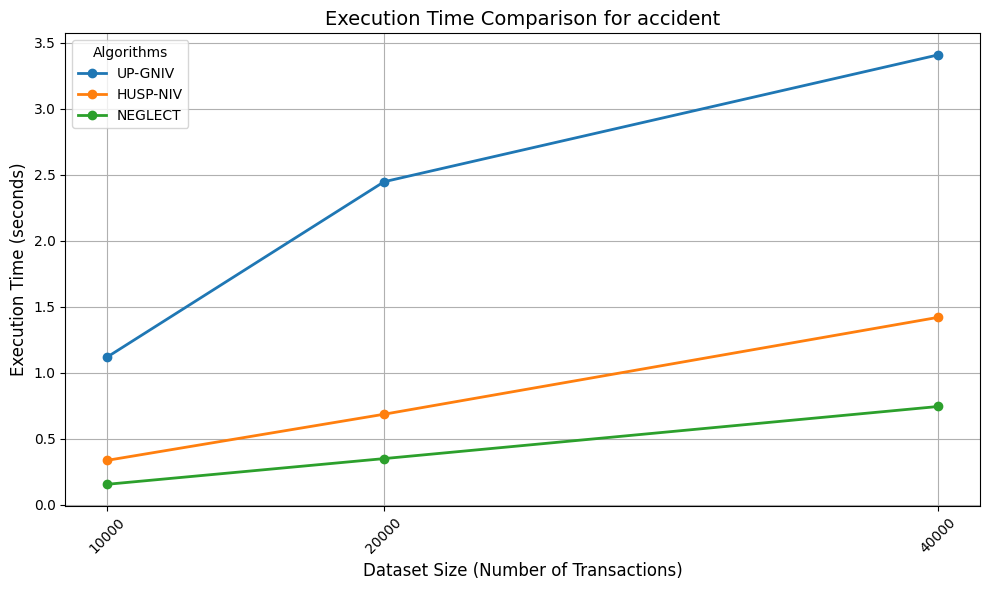

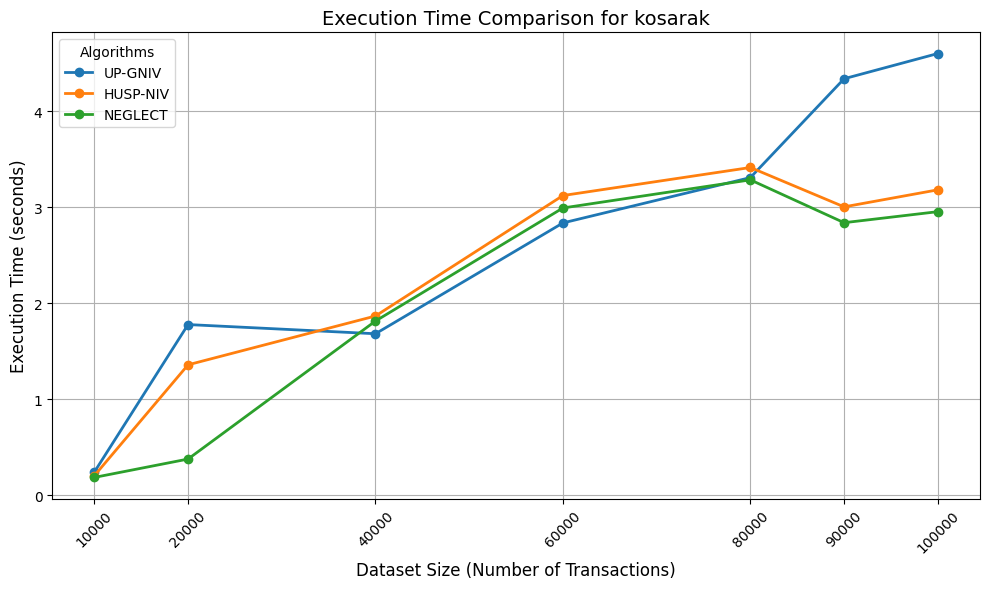

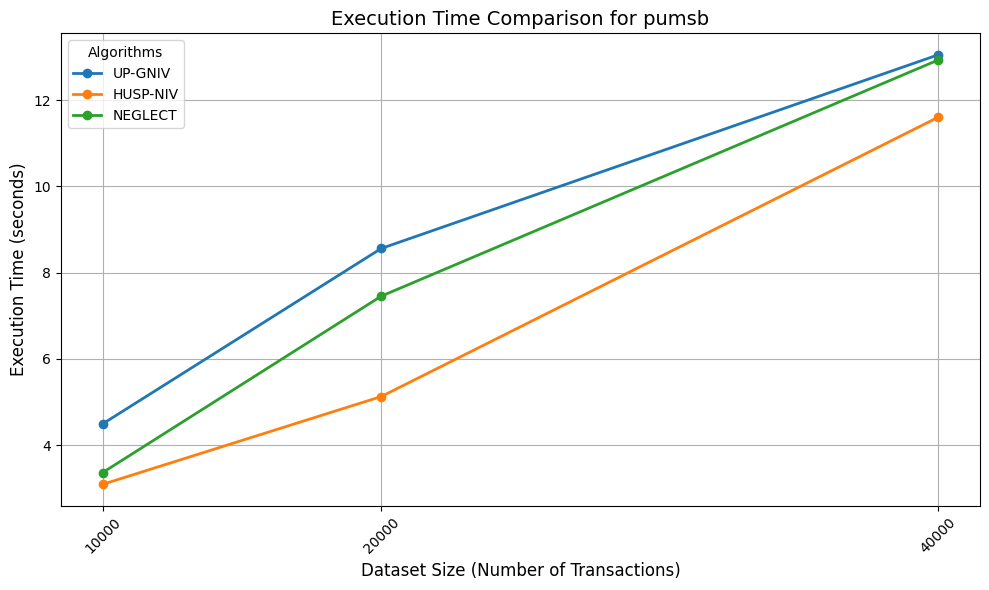

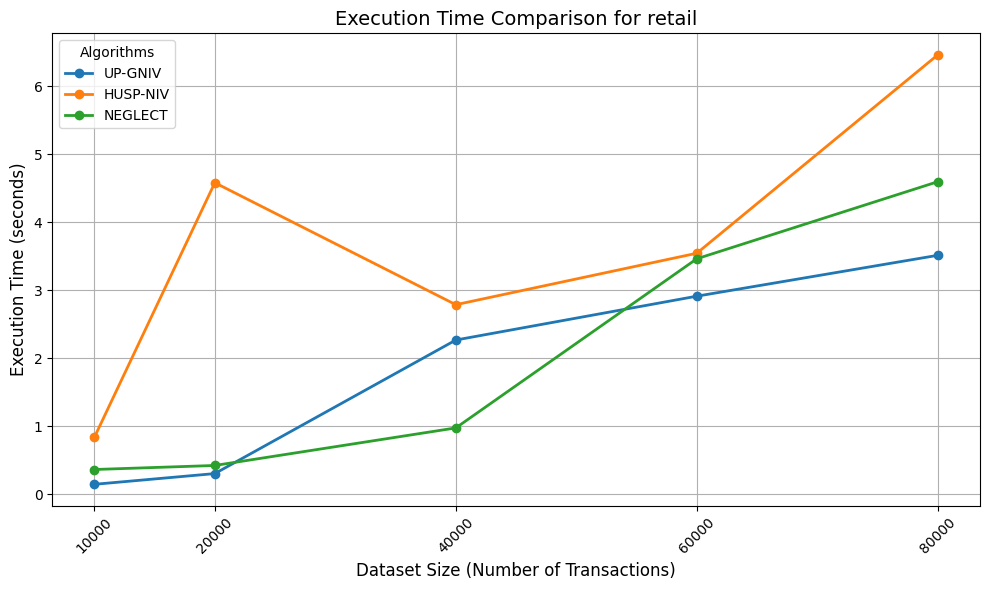

In [ ]:
algorithm_names = ['UP-GNIV', 'HUSP-NIV', 'NEGLECT']

# Ensure the execution times dictionary and item sizes are populated
if not execution_times:
    print("Execution times dictionary is empty. Please run the algorithms first.")
else:
    # Iterate over the datasets to create individual graphs
    for dataset_name in execution_times:
        plt.figure(figsize=(10, 6))

        # Determine the maximum x-ticks based on the dataset size
        dataset_size = len(bagOfData[dataset_name])
        max_x = min(dataset_size, 100000)
        x_ticks = [size for size in item_sizes if size <= max_x]

        # Plot each algorithm's execution time
        for algorithm_name in algorithm_names:
            times = execution_times[dataset_name][algorithm_name]

            # Ensure the lengths of x_ticks and times match
            if len(times) > len(x_ticks):
                times = times[:len(x_ticks)]

            plt.plot(x_ticks, times, marker='o', linestyle='-', linewidth=2, markersize=6, label=algorithm_name)

        # Configure graph details
        plt.xlabel('Dataset Size (Number of Transactions)', fontsize=12)
        plt.ylabel('Execution Time (seconds)', fontsize=12)
        plt.title(f'Execution Time Comparison for {dataset_name}', fontsize=14)
        plt.xticks(x_ticks, rotation=45)
        plt.grid(True)
        plt.legend(title="Algorithms", fontsize=10)
        plt.tight_layout()

        # Show the plot for the current dataset
        plt.show()

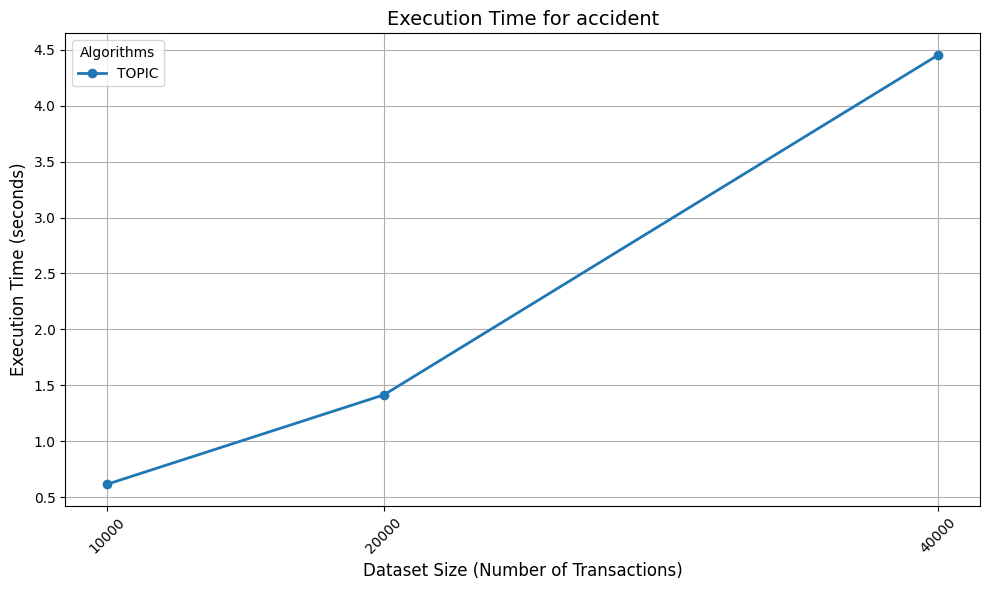

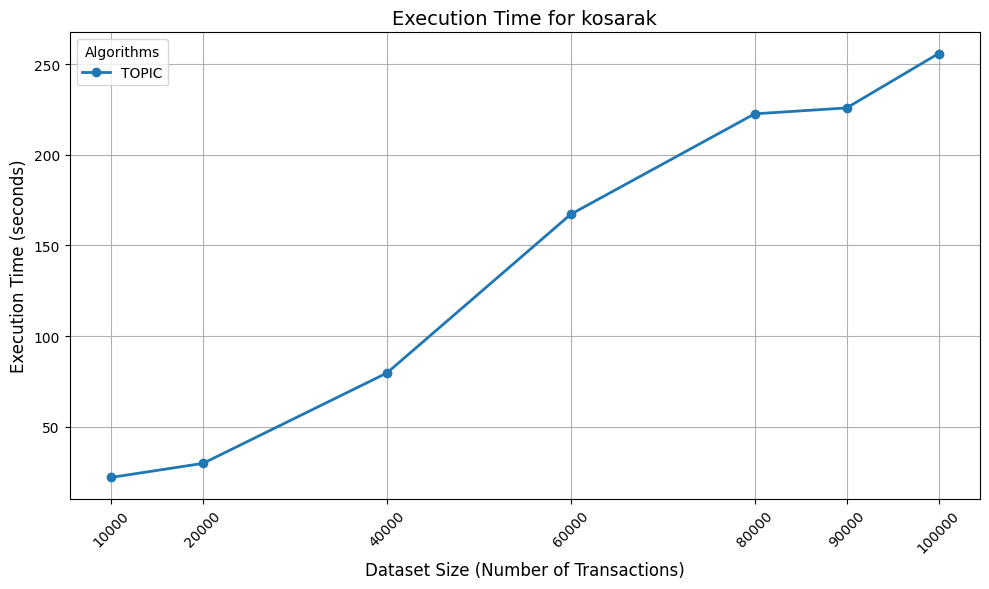

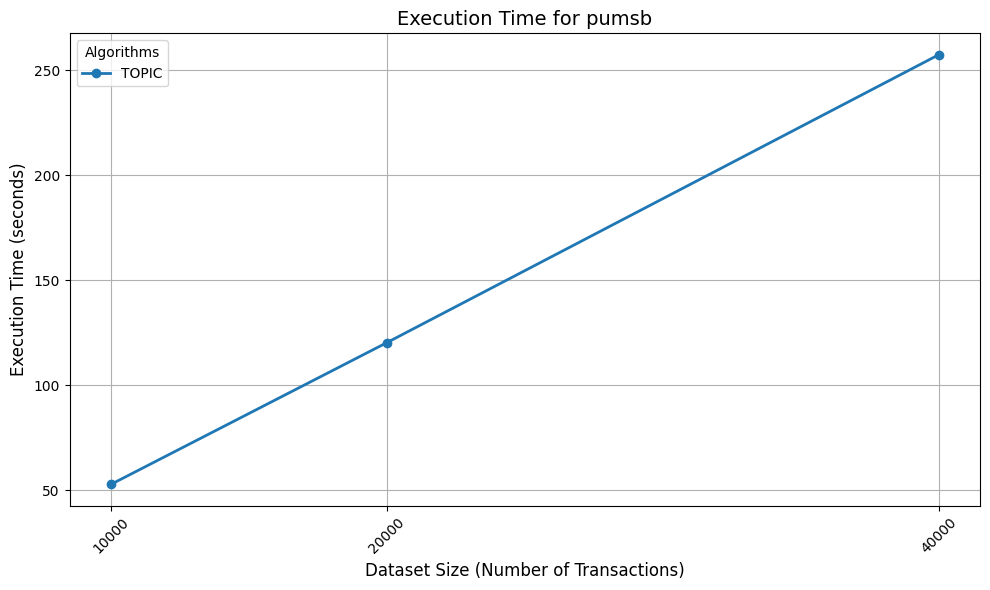

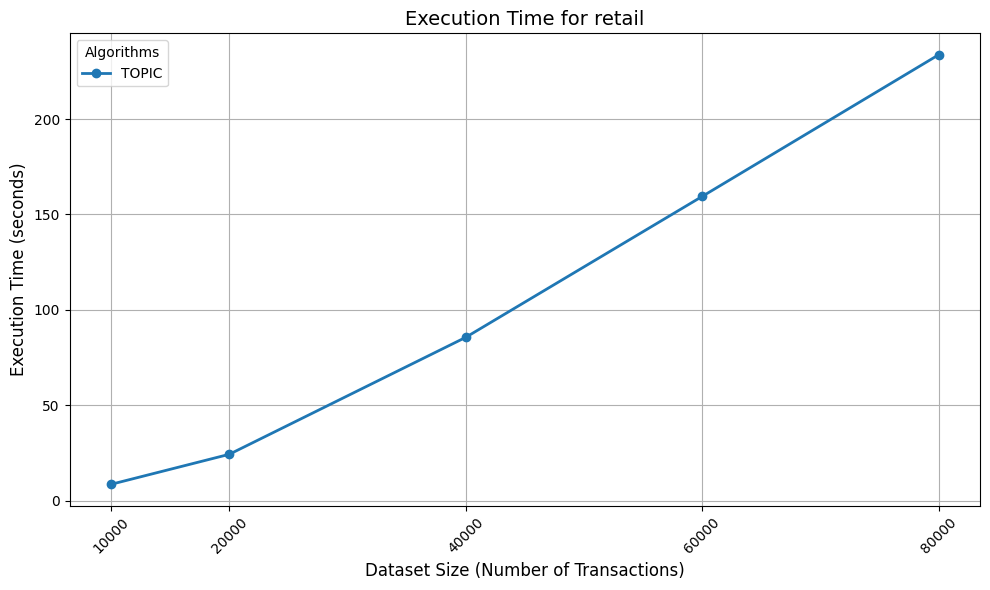

In [ ]:
algorithm_name = "TOPIC"
# Ensure the execution times dictionary and item sizes are populated
if not execution_times:
    print("Execution times dictionary is empty. Please run the algorithms first.")
else:
    # Iterate over the datasets to create individual graphs
    for dataset_name in execution_times:
        plt.figure(figsize=(10, 6))

        # Determine the maximum x-ticks based on the dataset size
        dataset_size = len(bagOfData[dataset_name])
        max_x = min(dataset_size, 100000)
        x_ticks = [size for size in item_sizes if size <= max_x]

        times = execution_times[dataset_name][algorithm_name]

        # Ensure the lengths of x_ticks and times match
        if len(times) > len(x_ticks):
            times = times[:len(x_ticks)]

        plt.plot(x_ticks, times, marker='o', linestyle='-', linewidth=2, markersize=6, label=algorithm_name)

        # Configure graph details
        plt.xlabel('Dataset Size (Number of Transactions)', fontsize=12)
        plt.ylabel('Execution Time (seconds)', fontsize=12)
        plt.title(f'Execution Time for {dataset_name}', fontsize=14)
        plt.xticks(x_ticks, rotation=45)
        plt.grid(True)
        plt.legend(title="Algorithms", fontsize=10)
        plt.tight_layout()

        # Show the plot for the current dataset
        plt.show()

*  **Length of accident dataset: 51313**
*  **Length of kosarak dataset: 294682**
*  **Length of pumsb dataset: 47473**
*  **Length of retail dataset: 88162**